In [1]:
import tensorflow as tf
print(tf.__version__)
# import libarries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# library for train test split
from sklearn.model_selection import train_test_split

# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D,  Flatten, Dense, Dropout, LSTM, SpatialDropout1D, Bidirectional


2.17.0


## Carregar e tratar os dados

In [2]:
url = 'https://raw.githubusercontent.com/ShresthaSudip/SMS_Spam_Detection_DNN_LSTM_BiLSTM/master/SMSSpamCollection'
messages = pd.read_csv(url, sep ='\t',names=["label", "message"])
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [3]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [4]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls


In [5]:
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In [6]:
# get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']

# For ham and spam messages, create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

In [7]:
ham_msg_text[:300]

"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... Ok lar... Joking wif u oni... U dun say so early hor... U c already then say... Nah I don't think he goes to usf, he lives around here though Even my brother is not like to speak with me. "

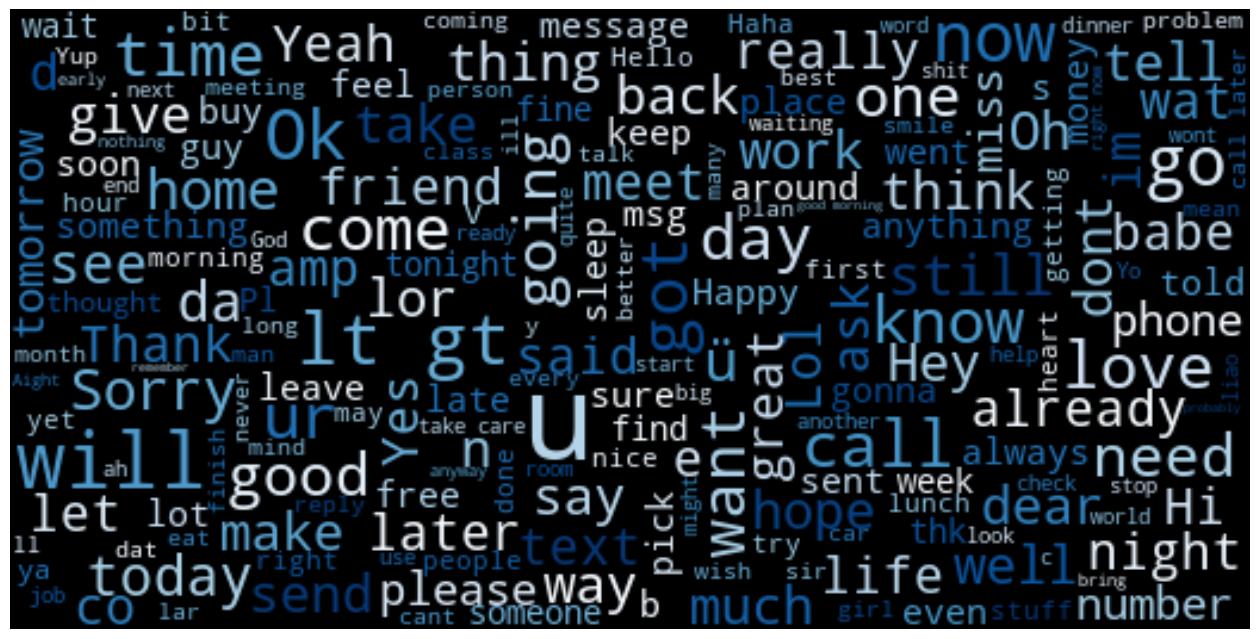

In [8]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, 
                          background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

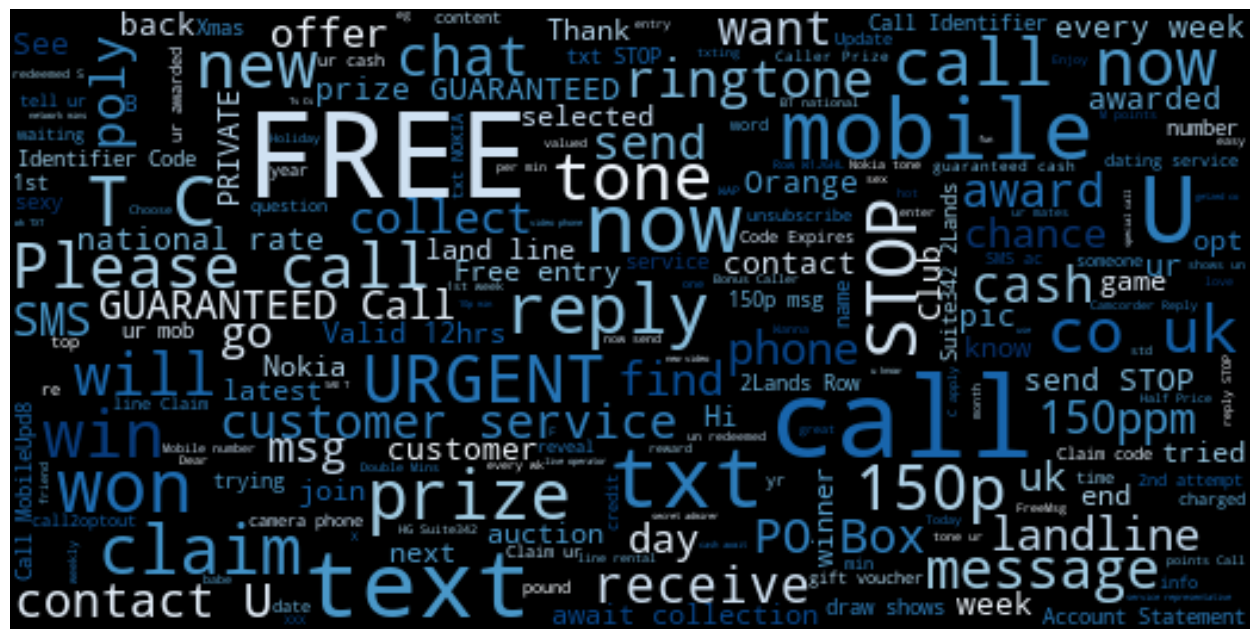

In [9]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, 
                          background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

C:\Users\cesar\AppData\Local\Temp\ipykernel_33336\2195443256.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=messages, x='label', palette='viridis')


Text(0, 0.5, 'Count')

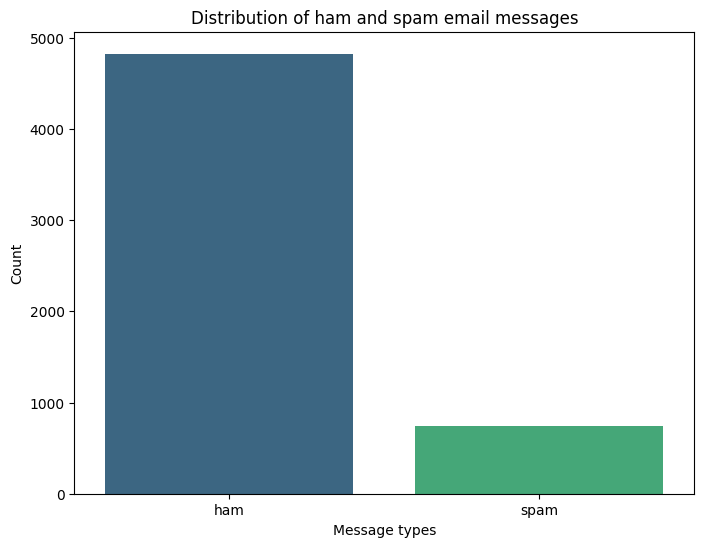

In [10]:
# we can observe imbalance data here. 
plt.figure(figsize=(8,6))
sns.countplot(data=messages, x='label', palette='viridis')
plt.title('Distribution of ham and spam email messages')
plt.xlabel('Message types')
plt.ylabel('Count')

In [11]:
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100

15.481865284974095

In [12]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg

In [13]:
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


In [14]:
# Create a dataframe with these ham and spam msg
msg_df = pd.concat([ham_msg_df, spam_msg_df]).reset_index(drop=True)

C:\Users\cesar\AppData\Local\Temp\ipykernel_33336\1694272589.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=msg_df, x='label', palette='viridis')


Text(0, 0.5, 'Count')

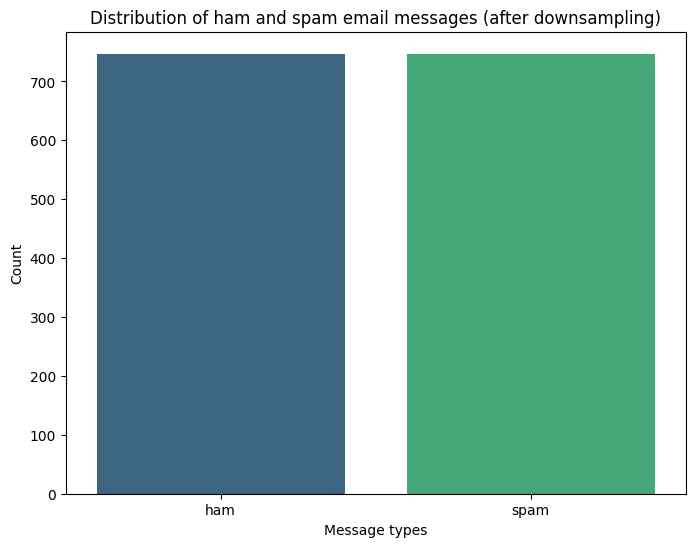

In [15]:
plt.figure(figsize=(8,6))
sns.countplot(data=msg_df, x='label', palette='viridis')
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')
plt.ylabel('Count')

In [16]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)

#Calculate average length by label types
labels = msg_df.groupby('label')['text_length'].mean()
labels

label
ham      73.238286
spam    138.670683
Name: text_length, dtype: float64

## Preparando dados de teste e pre processamento

In [17]:
#msg_df['msg_type']= msg_df['label'].apply(lambda x: 1 if x =='spam' else 0)
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values

In [18]:
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

In [19]:
# Defining pre-processing hyperparameters
max_len = 50 # pad_sequencs parameter, it idicates we are only going to look for 50 words in a sentence
trunc_type = "post" # pad_sequences parameter
padding_type = "post" # pad_sequences parameter
oov_tok = "<OOV>" # out of vocabulary token
vocab_size = 500

In [20]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [21]:
# Get the word_index
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'u': 8,
 'your': 9,
 'for': 10,
 'is': 11,
 '2': 12,
 'and': 13,
 'now': 14,
 'free': 15,
 'or': 16,
 'on': 17,
 'in': 18,
 'ur': 19,
 'have': 20,
 '4': 21,
 'txt': 22,
 'of': 23,
 'are': 24,
 'with': 25,
 'me': 26,
 'from': 27,
 'text': 28,
 'get': 29,
 'my': 30,
 'it': 31,
 'stop': 32,
 'just': 33,
 'mobile': 34,
 'this': 35,
 'will': 36,
 'be': 37,
 'no': 38,
 'that': 39,
 'claim': 40,
 'reply': 41,
 'can': 42,
 'so': 43,
 'send': 44,
 'www': 45,
 'we': 46,
 'only': 47,
 'our': 48,
 'not': 49,
 'out': 50,
 'at': 51,
 'do': 52,
 'if': 53,
 'prize': 54,
 'new': 55,
 'go': 56,
 'cash': 57,
 'but': 58,
 '150p': 59,
 'uk': 60,
 '1': 61,
 'nokia': 62,
 'who': 63,
 't': 64,
 'all': 65,
 'win': 66,
 'please': 67,
 'won': 68,
 'up': 69,
 'tone': 70,
 'when': 71,
 "i'm": 72,
 'week': 73,
 'been': 74,
 'what': 75,
 'msg': 76,
 '50': 77,
 'com': 78,
 'urgent': 79,
 'how': 80,
 'service': 81,
 'phone': 82,
 'time': 83,
 

In [22]:
# check how many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4169 unique tokens in training data. 


In [23]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, 
                                 padding = padding_type, truncating = trunc_type )

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                              padding = padding_type, truncating = trunc_type)

In [24]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [25]:
# Before padding : first sequence is 27 character long where as second one is 24
len(training_sequences[0]), len(training_sequences[1])

(27, 24)

In [26]:
# Padded to same length of 50
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [27]:
# As can be seen from below, the padded sequence is 50 words long. 
print(training_padded[0])

[  1  47 186   9  34   1   3  24   1   2 274   2   7 152 275 135  34  10
  15   6   7  34 274  85  15  17   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


## Treinando o modelo

In [28]:
#LSTM layer arcitecture hyperparameters
n_lstm = 20 # number of LSTM units / neurons
drop_lstm = 0.2
vocab_size = 500 # Number of words you want to tokenize i.e maximum number of words to keep
embeding_dim = 16

In [29]:
#LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Flatten())
model1.add(Dense(1, activation='sigmoid'))

c:\Users\cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [31]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 7s - 177ms/step - accuracy: 0.7732 - loss: 0.5612 - val_accuracy: 0.8060 - val_loss: 0.4518
Epoch 2/30


In [ ]:
# Create a dataframe
metrics = pd.DataFrame(history.history)

# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

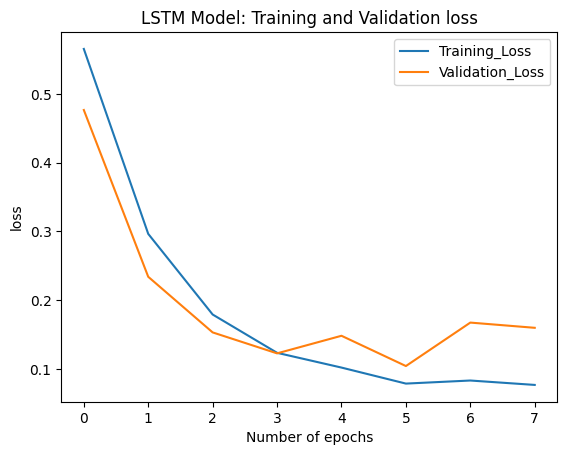

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

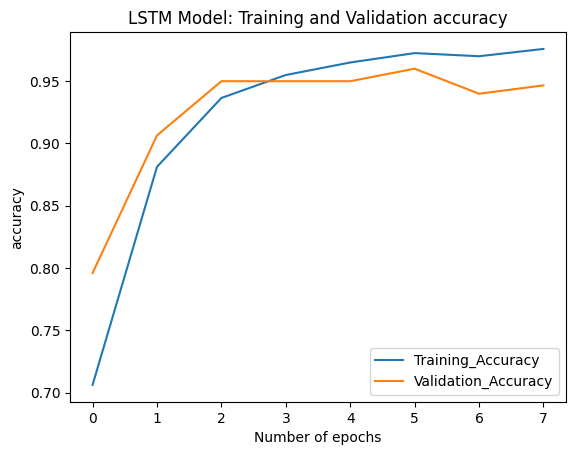

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

# Previsão para novas mensagens

In [ ]:
# display long string 
pd.options.display.max_colwidth=100
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...


In [ ]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model1.predict(padded))

In [ ]:
predict_spam(predict_msg)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


array([[0.04896471],
       [0.00311337],
       [0.9999998 ]], dtype=float32)

In [ ]:
# The third one gives 0.99 indicating very high probabilty of spam
predict_msg = ["You are awarded a Nikon Digital Camera. Call now",
               "Call me",
          "What's up?"]
predict_spam(predict_msg)